In [14]:
from doctest import testfile

import numpy as np
import matplotlib.pyplot as plt

## CODIFICADOR

In [2]:
bits = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
SF = 7
SF_Validos = [7, 8, 9, 10, 11, 12]

def coder(bits, SF):
    #Verificar si SF es valido
    if SF not in SF_Validos:
        raise ValueError("Invalido")
    #Verificar que la cantidad de bits sea multiplo del SF
    if len(bits) % SF != 0:
        raise ValueError("Numero de bits no es multiplo de SF")

       # Inicialización del vector de símbolos
    N_simbolos = len(bits) // SF
    s = np.zeros(N_simbolos, dtype=int)

    # Implementación de la ecuación (1)
    for i in range(N_simbolos):
        for h in range(SF):
            s[i] += bits[i * SF + h] * (2 ** h)

    return s

print(coder(bits, SF))

[57 20]


###  Ejemplo de codificación usando la Ecuación (1)

#### Datos de entrada:

- `bits = [1, 0, 0, 1, 1, 1, 0]`
- `SF = 7`

#### Desarrollo paso a paso:

Agrupamos los 7 bits como un único símbolo, ya que `SF = 7`.

$\begin{aligned}
s &= w_0 \cdot 2^0 + w_1 \cdot 2^1 + w_2 \cdot 2^2 + w_3 \cdot 2^3 + w_4 \cdot 2^4 + w_5 \cdot 2^5 + w_6 \cdot 2^6 \\
  &= 1 \cdot 2^0 + 0 \cdot 2^1 + 0 \cdot 2^2 + 1 \cdot 2^3 + 1 \cdot 2^4 + 1 \cdot 2^5 + 0 \cdot 2^6 \\
  &= 1 \cdot 1 + 0 \cdot 2 + 0 \cdot 4 + 1 \cdot 8 + 1 \cdot 16 + 1 \cdot 32 + 0 \cdot 64 \\
  &= 1 + 0 + 0 + 8 + 16 + 32 + 0 \\
  &= 57
\end{aligned}$


####  Resultado esperado:

```python
[57]


## DECODIFICADOR

In [3]:
def decoder(s, SF):
    # Verificar que SF sea válido
    if SF not in SF_Validos:
        raise ValueError("SF inválido")

    bits_recuperados = []

    # Por cada símbolo, reconstruir los SF bits
    for simbolo in s:
        #bits_simbolos=[]
        for h in range(SF):
            # Obtener el bit de orden h (menos significativo primero)
            bit = (simbolo >> h) & 1
            bits_recuperados.append(bit)
        #bits_recuperados.append(bits_simbolos)

    return bits_recuperados
print(decoder([57,20], 7))

[1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]


### Decodificación manual del símbolo (Ecuación inversa de la codificación)

#### Dato recibido:

- Símbolo codificado: `s = 57`
- Spreading Factor: `SF = 7`

Queremos obtener los 7 bits originales que generaron este símbolo.


#### Desarrollo paso a paso:

| h (posición del bit) | Cálculo                          | Resultado `w_h` |
|----------------------|----------------------------------|-----------------|
| 0                    | \( (57 >> 0) \& 1 = 57 \& 1 \)   | 1               |
| 1                    | \( (57 >> 1) \& 1 = 28 \& 1 \)   | 0               |
| 2                    | \( (57 >> 2) \& 1 = 14 \& 1 \)   | 0               |
| 3                    | \( (57 >> 3) \& 1 = 7 \& 1 \)    | 1               |
| 4                    | \( (57 >> 4) \& 1 = 3 \& 1 \)    | 1               |
| 5                    | \( (57 >> 5) \& 1 = 1 \& 1 \)    | 1               |
| 6                    | \( (57 >> 6) \& 1 = 0 \& 1 \)    | 0               |



In [4]:
bit_randoms=np.random.randint(0,2,14)
Codificador = coder(bit_randoms, 7)
Decodificados = decoder(Codificador, 7)

def errores(lista1, lista2):

    error=0
    for i,j in zip(lista1, lista2):
        if (i != j):
            error+=1
    return error

def ber():
    BER=errores(Decodificados,bit_randoms)/len(bit_randoms)
    return BER

print(ber())

0.0


### Waveformer Former

In [12]:
def waveform_former(s, SF):
    M = 2 ** SF  # cantidad de muestras por chirp
    chirps = []

    for simbolo in s:
        k = np.arange(M)
        fase = ((simbolo + k) % M) * k / M
        chirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
        chirps.append(chirp)

    return np.array(chirps)  # matriz [N x M]




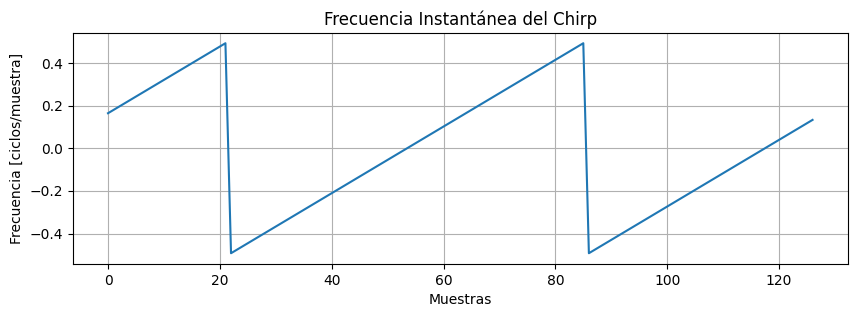

In [15]:

fase = np.unwrap(np.angle(chirp))
frecuencia_inst = np.diff(fase) / (2 * np.pi)  # en ciclos por muestra

plt.figure(figsize=(10, 3))
plt.plot(frecuencia_inst)
plt.title("Frecuencia Instantánea del Chirp")
plt.xlabel("Muestras")
plt.ylabel("Frecuencia [ciclos/muestra]")
plt.grid(True)
plt.show()


### n-Tuple Former

In [6]:
def n_tuple_former(received_chirps, SF):
    M = 2 ** SF
    k = np.arange(M)
    downchirp = np.exp(-1j * 2 * np.pi * k**2 / M)

    simbolos_estimados = []
    for chirp in received_chirps:
        producto = chirp * downchirp
        fft_producto = np.fft.fft(producto) #Es la Transformada Rápida de Fourier (FFT) en NumPy
        simbolo_estimado = np.argmax(np.abs(fft_producto))
        simbolos_estimados.append(simbolo_estimado)

    return np.array(simbolos_estimados)


In [27]:
# Definimos funciones de utilidad
def errores_simbolos(s_tx, s_rx):
    #Cuenta cuántos símbolos difieren entre dos listas
    error = 0
    for i, j in zip(s_tx, s_rx):
        if i != j:
            error += 1
    return error

def ser(s_tx, s_rx):
    #
    return errores_simbolos(s_tx, s_rx) / len(s_tx)


In [28]:
SF = 7
bit_randoms = np.random.randint(0, 2, SF * 2)  # 2 símbolos

# Transmisor
s_tx = coder(bit_randoms, SF)
chirps_tx = waveform_former(s_tx, SF)

# Receptor (sin canal)
s_rx = n_tuple_former(chirps_tx, SF)

# Calcular SER
print("Símbolos transmitidos:", s_tx[:10])
print("Símbolos decodificados:", s_rx[:10])
print("SER:", ser(s_tx, s_rx))

Símbolos transmitidos: [86 60]
Símbolos decodificados: [86 60]
SER: 0.0


### Implementación del ruido AWGN

In [29]:
def energia_promedio_chirp(chirps):
    return np.mean(np.sum(np.abs(chirps)**2, axis=1))

In [30]:
def agregar_ruido_AWGN(chirps, SNR_dB):
    M = chirps.shape[1]  # cantidad de muestras por chirp
    SNR_linear = 10**(SNR_dB / 10)

    Es = energia_promedio_chirp(chirps)
    sigma2 = Es / (2 * SNR_linear)

    ruido = np.sqrt(sigma2) * (np.random.randn(*chirps.shape) + 1j * np.random.randn(*chirps.shape))
    return chirps + ruido

## 🧪 Canal con Ruido AWGN y Curva BER/SER

### AWGN (Additive White Gaussian Noise)
Es un modelo de canal donde el ruido se suma a la señal transmitida:
- Media: 0
- Varianza: σ² = Eₛ / (2·SNRₗᵢₙₑₐᵣ)

Donde:

$\begin{aligned}
\text{SNR}_{\text{linear}} = 10^{\frac{\text{SNR}_{dB}}{10}}, \quad
\sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}
\end{aligned}$



### Procedimiento:
1. Se genera una señal chirp (modulada) por símbolo.
2. Se suma ruido Gaussiano complejo a la señal transmitida.
3. Se decodifica usando n-Tuple Former + FFT.
4. Se comparan los símbolos y bits originales con los decodificados.
5. Se calcula y grafica:
   - **BER**: tasa de error de bit.
   - **SER**: tasa de error de símbolo.